# Sports Data Scraping

## This script will attempt to scrape player data from ESPN to determine the most significant factors that can predict varying levels of batting success for the top 350 players.
* Based on stats, predict if a player will bat above .325


In [3]:
# Importing packages
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
import requests
import csv
import pandas as pd
import re
import warnings
import scipy

warnings.filterwarnings("ignore")

In [4]:
# Define a more realistic user agent to bypass potential 403 blocks
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36"
    )
}

# Getting URL page and converting it to soup
url = 'https://www.espn.com/mlb/history/leaders/_/breakdown/season/year/2024'
text_page = requests.get(url, headers=headers)
soup_page = soup(text_page.text, 'html.parser')

# Safely find the header row
headers_row = soup_page.find('tr', attrs={'class': 'colhead'})
if not headers_row:
    print("Did not find the header row. Possibly a 403 or changed structure.")
    # Optionally raise an error or handle differently:
    # raise ValueError("Could not locate header row in the page HTML.")

# Grab column names from the header row
columns = [col.get_text() for col in headers_row.find_all('td')]
players_stats_2024_df = pd.DataFrame(columns=columns)

# Loop through pagination (example: from 1 to 300, in steps of 50)
for i in range(1, 350, 50):
    paged_url = f'https://www.espn.com/mlb/history/leaders/_/breakdown/season/year/2024/start/{i}'
    text_page = requests.get(paged_url, headers=headers)
    soup_page = soup(text_page.text, 'html.parser')
    
    # Find all table rows that match the player class pattern
    players_2024 = soup_page.find_all('tr', attrs={'class': re.compile('row player-10-')})
    
    for player in players_2024:
        # Extract the text from all <td> tags
        stats = [stat.get_text() for stat in player.find_all('td')]
        
        # Create a temporary one-row DataFrame
        temp_df = pd.DataFrame([stats], columns=columns)
        
        # Append the row to the overall DataFrame
        players_stats_2024_df = pd.concat([players_stats_2024_df, temp_df], ignore_index=True)

players_stats_2024_df.reset_index(drop=True, inplace=True)
players_stats_2024_df.head()

,,PLAYER,YRS,G,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,CS,BA
0,1,Jose Iglesias,13,85,270,39,91,16,1,4,26,12,39,6,2,.337
1,2,Bobby Witt Jr.,4,161,636,125,211,45,11,32,109,57,106,31,12,.332
2,3,Xavier Edwards,3,70,265,39,87,12,5,1,26,33,52,31,4,.328
3,4,Vladimir Guerrero Jr.,7,159,616,98,199,44,1,30,103,72,96,2,2,.323
4,5,Aaron Judge,10,158,559,122,180,36,1,58,144,133,171,10,0,.322


In [5]:
##Saving dataframe to csv
# players_stats_2024_df.to_csv("players_stats_2024.csv", index = False, sep =',', encoding = 'utf-8')

In [7]:
players_stats_2024_df.shape

(350, 16)

<Axes: >

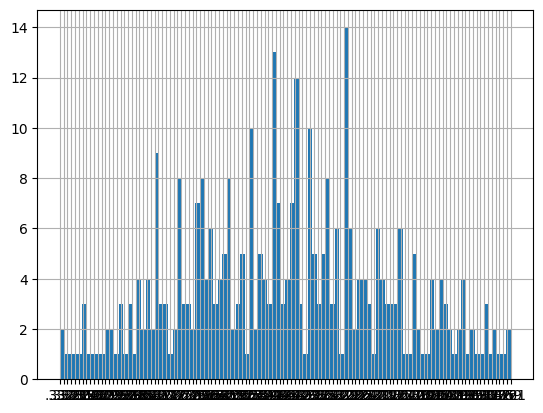

In [8]:
players_stats_2024_df['BA'].hist(bins=100)

## PCA ON Baseball Data To Determine Which Stats Best Predict Batting Average



In [14]:
#Import required libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn import preprocessing, decomposition

In [16]:
# Label creation
# "GREAT", "GOOD", "OKAY", "BELOW AVERAGE", "POOR"
#1: BA >= .325 (GREAT)
#2: BA < .325 and >= 0.300 (GOOD)
#3: BA < 0.300 and >= 0.250 (OKAY)
#4: BA < 0.250 and >= 0.200 (BELOW AVERAGE)
#5: BA < 0.200 (POOR)

# **** DISCLAIMER: Because this data set consists of the top 300 players in the league based 
# on batting average, we are missing a significant portion of the league who are batting below 0.250

column = ['Rating_Label']
temp_lbls = []
for i in range(0,len(players_stats_2024_df.PLAYER)):
    if (float(players_stats_2024_df.BA[i]) >= 0.325):
        temp_lbl = 1
    if (float(players_stats_2024_df.BA[i]) < 0.325 and float(players_stats_2024_df.BA[i]) >= 0.300):
        temp_lbl = 2
    if (float(players_stats_2024_df.BA[i]) < 0.300 and float(players_stats_2024_df.BA[i]) >= 0.250):
        temp_lbl = 3
    if (float(players_stats_2024_df.BA[i]) < 0.250 and float(players_stats_2024_df.BA[i]) >= 0.200):
        temp_lbl = 4
    if (float(players_stats_2024_df.BA[i]) < 0.200 and float(players_stats_2024_df.BA[i]) >= 0):
        temp_lbl = 5
    temp_lbls.append(temp_lbl)    
    temp_df = pd.DataFrame(data=temp_lbls, columns = column)
    mlb_2024_players_lbl = pd.concat([players_stats_2024_df, temp_df], axis=1)


del temp_df

In [18]:
mlb_2024_players_lbl.head()

,,PLAYER,YRS,G,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,CS,BA,Rating_Label
0,1,Jose Iglesias,13,85,270,39,91,16,1,4,26,12,39,6,2,.337,1
1,2,Bobby Witt Jr.,4,161,636,125,211,45,11,32,109,57,106,31,12,.332,1
2,3,Xavier Edwards,3,70,265,39,87,12,5,1,26,33,52,31,4,.328,1
3,4,Vladimir Guerrero Jr.,7,159,616,98,199,44,1,30,103,72,96,2,2,.323,2
4,5,Aaron Judge,10,158,559,122,180,36,1,58,144,133,171,10,0,.322,2


In [20]:
# Features for PCA
cols_feat = ['YRS','G','AB','R', 'H','2B', '3B','HR', 'RBI', 'BB', 'SO', 'SB', 'CS']

# Extract the features
df_for_pca = mlb_2024_players_lbl[cols_feat]

# Remove rows with NaN
df_for_pca = df_for_pca.dropna()

# Checking for null values
df_for_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   YRS     350 non-null    object
 1   G       350 non-null    object
 2   AB      350 non-null    object
 3   R       350 non-null    object
 4   H       350 non-null    object
 5   2B      350 non-null    object
 6   3B      350 non-null    object
 7   HR      350 non-null    object
 8   RBI     350 non-null    object
 9   BB      350 non-null    object
 10  SO      350 non-null    object
 11  SB      350 non-null    object
 12  CS      350 non-null    object
dtypes: object(13)
memory usage: 35.7+ KB


In [22]:
# Standardize the features
scaler = preprocessing.StandardScaler()
tmp = scaler.fit_transform(df_for_pca)
df_for_pca_zscored = pd.DataFrame(data=tmp, columns=cols_feat)
del tmp

# Setup the PCA object 
pca_obj = decomposition.PCA().fit(df_for_pca_zscored)

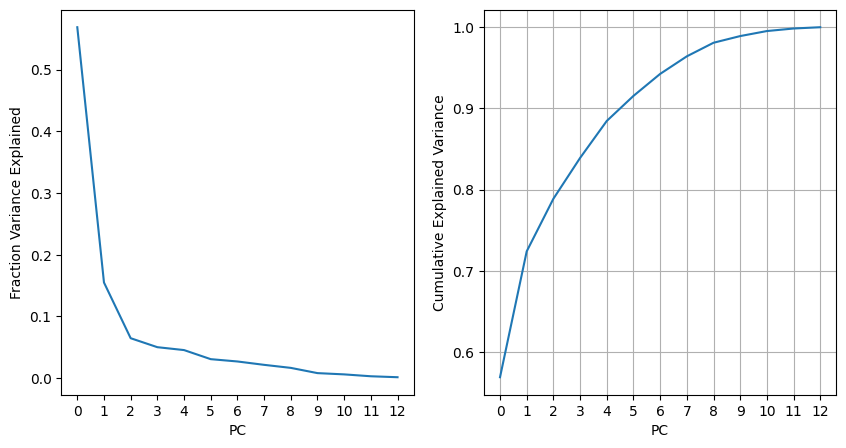

In [24]:
# Explained variance and cumulative explained variance for each PC
pcs_plot = np.arange(0,len(cols_feat))
pc_expl_var = pca_obj.explained_variance_ratio_[pcs_plot]
fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, figsize=(10,5))
ax1.plot(pcs_plot, pca_obj.explained_variance_ratio_[pcs_plot])
ax1.set_xticks(pcs_plot)
ax1.set_xlabel('PC')
ax1.set_ylabel('Fraction Variance Explained')

ax2.plot(np.cumsum(pca_obj.explained_variance_ratio_[pcs_plot]))
# ax2.xticks(pcs_plot)`
ax2.set_xlabel('PC')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.grid()

plt.show()

<Axes: >

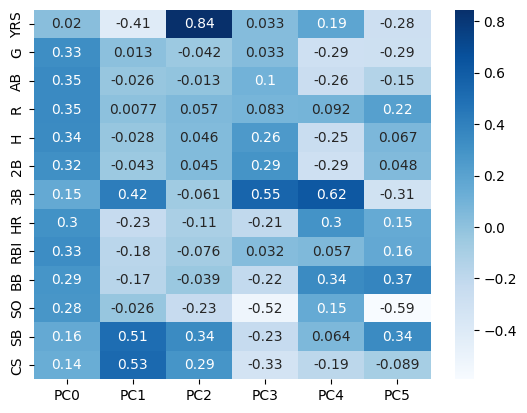

In [26]:
# Visualize loadings of the first few PCs
nPCs_ttl = len(pca_obj.components_) # number of PCs in total
nPCs = 6 # first n PCs to be selected
# the first 6 PCs (PC0 to PC5) explained roughly 90% of variance in total

# get loadings for PC, i.e. association of input features with each PC
loadings_mat = pca_obj.components_[0:nPCs, :]
# nPCs components x 11 features
loadings_mat.shape

cols_pc = ['PC'+str(i) for i in range(nPCs_ttl)]
loadings_df = pd.DataFrame(data = np.transpose(loadings_mat), 
                           index = cols_feat, 
                           columns = cols_pc[0:nPCs])
loadings_df.shape
sns.heatmap(loadings_df, xticklabels = True, yticklabels = True, cmap='Blues', annot=True)

In [28]:
# features ranked by association with PC 0
loadings_df['PC0'].sort_values(ascending = False)

R      0.350291
AB     0.349649
H      0.342729
RBI    0.331950
G      0.328076
2B     0.315557
HR     0.301671
BB     0.286007
SO     0.280775
SB     0.158844
3B     0.154765
CS     0.137623
YRS    0.020354
Name: PC0, dtype: float64

In [30]:
# features ranked by association with PC 1
loadings_df['PC1'].sort_values(ascending = False)

CS     0.529309
SB     0.506251
3B     0.419300
G      0.013035
R      0.007745
SO    -0.025844
AB    -0.026425
H     -0.027519
2B    -0.043213
BB    -0.168287
RBI   -0.179814
HR    -0.229940
YRS   -0.412290
Name: PC1, dtype: float64

In [32]:
# features ranked by association with PC 2
loadings_df['PC2'].sort_values(ascending = False)

YRS    0.844569
SB     0.343827
CS     0.287337
R      0.057465
H      0.046179
2B     0.045039
AB    -0.012602
BB    -0.039374
G     -0.042359
3B    -0.060849
RBI   -0.076365
HR    -0.105141
SO    -0.233172
Name: PC2, dtype: float64

In [34]:
# features ranked by association with PC 3
loadings_df['PC3'].sort_values(ascending = False)

3B     0.549887
2B     0.291117
H      0.260425
AB     0.102816
R      0.083385
G      0.033157
YRS    0.032998
RBI    0.031892
HR    -0.209874
BB    -0.216335
SB    -0.227404
CS    -0.326723
SO    -0.524421
Name: PC3, dtype: float64

In [64]:
loadings_df

,PC0,PC1,PC2,PC3,PC4,PC5
YRS,0.020354,-0.412290,0.844569,0.032998,0.186665,-0.281759
G,0.328076,0.013035,-0.042359,0.033157,-0.291118,-0.286305
AB,0.349649,-0.026425,-0.012602,0.102816,-0.259492,-0.148094
R,0.350291,0.007745,0.057465,0.083385,0.092470,0.220514
H,0.342729,-0.027519,0.046179,0.260425,-0.254977,0.067271
2B,0.315557,-0.043213,0.045039,0.291117,-0.291231,0.048129
3B,0.154765,0.419300,-0.060849,0.549887,0.620184,-0.307176
HR,0.301671,-0.229940,-0.105141,-0.209874,0.299909,0.153784
RBI,0.331950,-0.179814,-0.076365,0.031892,0.056815,0.161586
BB,0.286007,-0.168287,-0.039374,-0.216335,0.339755,0.374989


In [36]:
def plot2D_pcs(df, pc_x, pc_y, explVar_x, explVar_y, col_target, targets, colors):
    '''
    Plot a 2D scatter plot of PC scores
    Inputs:
        df - a dataframe containing the PC scores and the target column
        pc_x - the name of the PC to be plotted on x-axis (needs to match the column name in df)
        pc_y - the name of the PC to be plotted on y-axis (needs to match the column name in df)
        explVar_x - the variance explained by pc_x (between 0 and 1)
        explVar_y - the variance explained by pc_y (between 0 and 1)
        col_target - column name of the target (e.g., a cateogrical variable) in df
        targets - a list of unique values in the target column
        colors - a list of colors to be used for each unique value in the target column
    '''
    # conver the explained variance to a percentage value
    explVar_pct_x = round(explVar_x, 3)*100
    explVar_pct_y = round(explVar_y, 3)*100
    fig, ax = plt.subplots()
    str_xlabel = pc_x + ' (PVE: ' + str(explVar_pct_x) + ')'
    str_ylabel = pc_y + ' (PVE: ' + str(explVar_pct_y) + ')'
    ax.set_xlabel(str_xlabel)
    ax.set_ylabel(str_ylabel)
    for target, color in zip(targets,colors):
        idxToKeep = df[col_target] == target
        ax.scatter(df.loc[idxToKeep, pc_x], df.loc[idxToKeep, pc_y],
                   c = color,
                   alpha=0.3)
    ax.legend(targets)
    
    plt.show()

In [38]:
# Plot features and visualize both the distribution fo data and association of features with data

# PCA coordinates derived from standardized data
pca_coords = pca_obj.fit_transform(df_for_pca_zscored)#[:, 0:nPCs]
pca_coords = pd.DataFrame(data = pca_coords, columns = cols_pc)
pca_coords

# Combine PC coordinates with the continuous variables as well as customer ratings (target)
df_pca_pcs = pd.concat([df_for_pca, mlb_2024_players_lbl['Rating_Label'], pca_coords], axis = 1)
df_pca_pcs.head()

,YRS,G,AB,R,H,2B,3B,HR,RBI,BB,...,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,13,85,270,39,91,16,1,4,26,12,...,0.874619,-0.202171,-0.041390,-0.347500,-0.116271,0.141868,0.418797,-0.020101,0.000981,0.294522
1,4,161,636,125,211,45,11,32,109,57,...,2.205784,0.945669,0.576026,-1.428627,-1.563682,-0.115531,-0.029030,-0.122984,-0.046099,0.259628
2,3,70,265,39,87,12,5,1,26,33,...,0.504651,1.136909,1.222217,0.275194,0.469764,0.431901,0.341344,0.802102,0.151157,0.179873
3,7,159,616,98,199,44,1,30,103,72,...,1.239998,-1.143469,1.304179,-0.203176,-0.904105,0.295145,-0.018806,-0.002959,0.135989,0.302065
4,10,158,559,122,180,36,1,58,144,133,...,-1.327018,2.215089,2.413496,-0.135391,-0.575883,-0.000071,-0.484263,-0.043325,0.188730,0.489599


## Clustering Analysis


In [41]:
from sklearn import cluster, metrics, preprocessing

In [43]:
def do_kmeans(df, feats_use, k = 2, scale = 'yes'): #, col_name = 'cluster'
    # df = pandas DataFrame with numeric features
    # feats_use = list or array features columns to subset
#     modifies dataframe to contain cluster labels
    
    # if the features in df are not standardized yet
    if scale=='yes':
        df_raw = df.copy()
        scaler = preprocessing.StandardScaler()
        tmp = scaler.fit_transform(df[feats_use])
        df = pd.DataFrame(data=tmp, columns=feats_use)
        del tmp
        
    data_use = df[feats_use].to_numpy().astype('float64')   
    # setup + run kmeans
    kmeans_obj = cluster.KMeans(init='k-means++', n_clusters = k, random_state = 42)
    clust_labs = kmeans_obj.fit_predict(data_use)
    # conver clust_labs to string (categorical)
    clust_labs = clust_labs.astype('str')
    
    return clust_labs
#     df[col_name] = clust_labs

In [45]:
# Features for PCA
cols_feat = ['YRS','G','AB','R', 'H','2B', '3B','HR', 'RBI', 'BB', 'SO', 'SB', 'CS']

# Extract the features
df_for_pca = mlb_2024_players_lbl[cols_feat]

# Remove rows with NaN
df_for_pca = df_for_pca.dropna()

In [90]:
# Do clustering
nClusters = 3
clust5_batting_average = do_kmeans(df_for_pca, feats_use=cols_feat, k=nClusters)

# calculate the silhouette score (higher means better clustering performance)
s_score = metrics.silhouette_score(mlb_2024_players_lbl[cols_feat], clust5_batting_average, metric="euclidean")
print('Number of clusters =', str(nClusters), ': Silhouette score =', str(s_score))

Number of clusters = 3 : Silhouette score = 0.41443128236257515


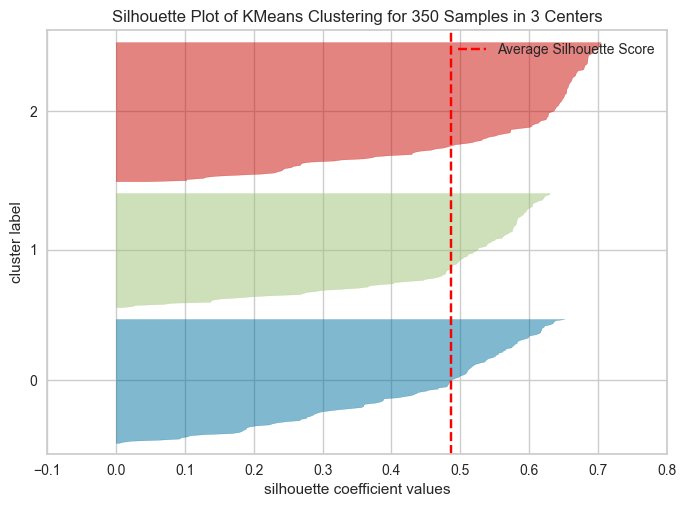

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 350 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=3, random_state=42))

In [92]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import silhouette_visualizer
from yellowbrick.datasets import load_credit

# Instantiate the clustering model and visualizer
#model = KMeans(2, random_state=42)
#visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
#
#visualizer.fit(mlb_2024_players_lbl[cols_feat])        # Fit the data to the visualizer
#visualizer.show()        # Finalize and render the figure

silhouette_visualizer(KMeans(3, random_state=42), mlb_2024_players_lbl[cols_feat], colors='yellowbrick')


## Running SVM to classify batting average labels

In [52]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [54]:
# Scaling the data between 0 and 1 for the purposes of SVM

for column in df_for_pca_zscored:
    temp = df_for_pca_zscored[cols_feat]
    scaled_temp = NormalizeData(temp)
    df_scaled_for_svm = pd.DataFrame(data=scaled_temp, columns=cols_feat)
    del temp
    del scaled_temp
    
    
df_scaled_for_svm_with_labels = pd.concat([df_scaled_for_svm, mlb_2024_players_lbl['Rating_Label']], axis = 1)
df_scaled_for_svm_with_labels.head()

,YRS,G,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,CS,Rating_Label
0,0.488421,0.123484,0.146131,0.197471,0.244890,0.224215,0.231826,0.141059,0.141086,0.115070,0.084433,0.241103,0.258580,1
1,0.178173,0.458654,0.500294,0.656991,0.636303,0.640316,0.822729,0.516297,0.575393,0.403064,0.299781,0.542365,0.721458,1
2,0.143701,0.057332,0.141293,0.197471,0.231842,0.166822,0.468187,0.100855,0.141086,0.249467,0.126217,0.542365,0.351156,1
3,0.281589,0.449834,0.480941,0.512723,0.597161,0.625967,0.231826,0.489494,0.543997,0.499062,0.267640,0.192901,0.258580,2
4,0.385005,0.445424,0.425784,0.640961,0.535188,0.511181,0.231826,0.864732,0.758534,0.889453,0.508702,0.289305,0.166004,2


In [56]:
#Running SVM with only features from all that were included in PCA

import random
import numpy as np
import numpy.matlib
import sklearn 
import matplotlib.pyplot as plt
import itertools
import multiprocessing as mp
recall_all_feats = []
accuracy_all_feats = []
precision_all_feats = []

all_combos = np.array(list(itertools.combinations(range(0, df_scaled_for_svm_with_labels.Rating_Label.nunique()), 2)))
for x in range(0, all_combos.shape[0]):
    group1 = df_scaled_for_svm_with_labels[cols_feat].loc[(df_scaled_for_svm_with_labels.Rating_Label == all_combos[x, 0]+1)]
    group2 = df_scaled_for_svm_with_labels[cols_feat].loc[(df_scaled_for_svm_with_labels.Rating_Label == all_combos[x, 1]+1)]
    print("Computing combo", x+1, "of", all_combos.shape[0])
    #print("First group is", all_combos[x, 0]+1)
    #print("Second emotion is",all_combos[x, 1]+1)
    data_for_svm = np.concatenate((group1, group2), axis=0)
    #target labels
    targets = np.concatenate((np.matlib.repmat(1, group1.shape[0], 1), np.matlib.repmat(0, group2.shape[0], 1)), axis = 0)
    #data_for_svm = group1.append(group2)
    #building classifier
    from sklearn.model_selection import train_test_split
    #75% training and 25% test
    X_train, X_test, y_train, y_test = train_test_split(data_for_svm, targets, test_size=0.25,random_state=109) 
    #Import svm model
    from sklearn import svm
    #Create a svm Classifier
    clf = svm.SVC(kernel='linear') # Linear Kernel
    #Train the model using the training sets
    clf.fit(X_train, y_train.ravel())
    y_pred = clf.predict(X_test)
    #Import scikit-learn metrics module for accuracy calculation
    from sklearn import metrics
        # Model Accuracy: how often is the classifier correct?
        #print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
        # Model Precision: what percentage of positive tuples are labeled as such?
        #print("Precision:",metrics.precision_score(y_test, y_pred))
        # Model Recall: what percentage of positive tuples are labelled as such?
        #print("Recall:",metrics.recall_score(y_test, y_pred))
    recall_all_feats.append(metrics.recall_score(y_test, y_pred))
    accuracy_all_feats.append(metrics.accuracy_score(y_test, y_pred))
    precision_all_feats.append(metrics.precision_score(y_test, y_pred))

print("Average accuracy is ", np.mean(accuracy_all_feats, axis = 0))

Computing combo 1 of 10
Computing combo 2 of 10
Computing combo 3 of 10
Computing combo 4 of 10
Computing combo 5 of 10
Computing combo 6 of 10
Computing combo 7 of 10
Computing combo 8 of 10
Computing combo 9 of 10
Computing combo 10 of 10
Average accuracy is  0.8975953935054262


In [58]:
# Informed by PCA, taking the top 5 features from the first PC
top5_features = ['R', 'AB', 'H', 'RBI', 'G']

In [60]:
#Running SVM with only features from the top 5 PC's identified using PCA

recall_top5_feats = []
accuracy_top5_feats = []
precision_top5_feats = []

all_combos = np.array(list(itertools.combinations(range(0, df_scaled_for_svm_with_labels.Rating_Label.nunique()), 2)))
for x in range(0, all_combos.shape[0]):
    group1 = df_scaled_for_svm_with_labels[top5_features].loc[(df_scaled_for_svm_with_labels.Rating_Label == all_combos[x, 0]+1)]
    group2 = df_scaled_for_svm_with_labels[top5_features].loc[(df_scaled_for_svm_with_labels.Rating_Label == all_combos[x, 1]+1)]
    print("Computing combo", x+1, "of", all_combos.shape[0])
    #print("First group is", all_combos[x, 0]+1)
    #print("Second emotion is",all_combos[x, 1]+1)
    data_for_svm = np.concatenate((group1, group2), axis=0)
    #target labels
    targets = np.concatenate((np.matlib.repmat(1, group1.shape[0], 1), np.matlib.repmat(0, group2.shape[0], 1)), axis = 0)
    #data_for_svm = group1.append(group2)
    #building classifier
    from sklearn.model_selection import train_test_split
    #75% training and 25% test
    X_train, X_test, y_train, y_test = train_test_split(data_for_svm, targets, test_size=0.25,random_state=109) 
    #Import svm model
    from sklearn import svm
    #Create a svm Classifier
    clf = svm.SVC(kernel='linear') # Linear Kernel
    #Train the model using the training sets
    clf.fit(X_train, y_train.ravel())
    y_pred = clf.predict(X_test)
    #Import scikit-learn metrics module for accuracy calculation
    from sklearn import metrics
        # Model Accuracy: how often is the classifier correct?
        #print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
        # Model Precision: what percentage of positive tuples are labeled as such?
        #print("Precision:",metrics.precision_score(y_test, y_pred))
        # Model Recall: what percentage of positive tuples are labelled as such?
        #print("Recall:",metrics.recall_score(y_test, y_pred))
    recall_top5_feats.append(metrics.recall_score(y_test, y_pred))
    accuracy_top5_feats.append(metrics.accuracy_score(y_test, y_pred))
    precision_top5_feats.append(metrics.precision_score(y_test, y_pred))
    
# print('Average Recall = ', np.mean(recall_top5_feats, axis = 0))
print('Average Accuracy = ', np.mean(accuracy_top5_feats, axis = 0))
# print('Average Precision = ', np.mean(precision_top5_feats, axis = 0))


Computing combo 1 of 10
Computing combo 2 of 10
Computing combo 3 of 10
Computing combo 4 of 10
Computing combo 5 of 10
Computing combo 6 of 10
Computing combo 7 of 10
Computing combo 8 of 10
Computing combo 9 of 10
Computing combo 10 of 10
Average Accuracy =  0.8950637479358059


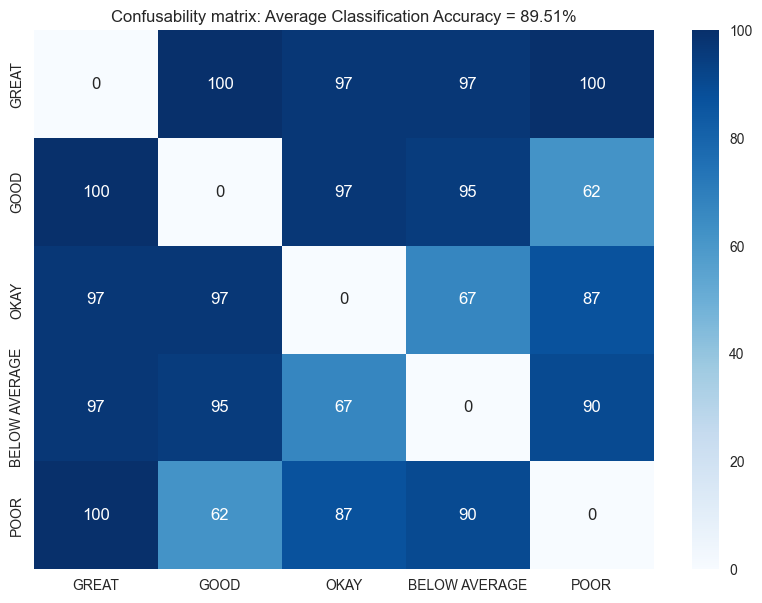

               GREAT  GOOD  OKAY  BELOW AVERAGE  POOR
GREAT              0   100    97             97   100
GOOD             100     0    97             95    62
OKAY              97    97     0             67    87
BELOW AVERAGE     97    95    67              0    90
POOR             100    62    87             90     0


In [62]:
# Visualizaing confusability matrices
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#Building confusability matrix
acc_conf_mat = scipy.spatial.distance.squareform(accuracy_top5_feats, force='yes', checks=True)
acc_conf_mat = acc_conf_mat*100

df_cm = pd.DataFrame(acc_conf_mat, index = [i for i in ["GREAT", "GOOD", "OKAY", "BELOW AVERAGE", "POOR"]],
                  columns = [i for i in ["GREAT", "GOOD", "OKAY", "BELOW AVERAGE", "POOR"]])
df_cm = df_cm.astype(int)

plt.figure(figsize=(10,7))

ax = sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')

# sn.heatmap(df_cm, annot=True, ax=ax)
ax.set_title(f'Confusability matrix: Average Classification Accuracy = {round(np.mean(accuracy_top5_feats, axis = 0)*100, 2)}%' ) 
plt.show()
print(df_cm)

# Summary


Through this analysis of **350 MLB players** from the 2024 season, we explored three primary avenues of baseball‐stat insights:

1. **Principal Component Analysis (PCA)**  
   - **Key Finding**: A single principal component (PC0) explained over half of the variance, heavily influenced by overall offensive volume (e.g., games played, at bats, hits).  
   - **Secondary Dimension**: Captured a speed vs. power dynamic, distinguishing base‐stealers from home‐run hitters.  
   - **Additional Component**: Highlighted player experience (years played).

2. **K-Means Clustering**  
   - **Method**: Grouped players into three clusters, producing a moderate silhouette score (~0.414).  
   - **Observations**: Each cluster loosely represents a batting archetype—power, speed, or balanced.  
   - **Comparison**: A five‐cluster approach yielded a lower silhouette score (~0.22), indicating more overlap.

3. **Pairwise SVM Classification**  
   - **Goal**: Predict batting average category (GREAT, GOOD, OKAY, BELOW AVERAGE, POOR) via linear SVM on a pairwise basis.  
   - **Performance**: Achieved ~89.5% accuracy using only the top 5 features (Runs, At Bats, Hits, RBI, Games), with minimal gains when adding more stats.  
   - **Confusability**: Most misclassifications occurred between adjacent BA ranges (e.g., OKAY vs. BELOW AVERAGE), reflecting closely clustered performance metrics.

**Overall**, these techniques provide a well‐rounded view of hitter performance. PCA pinpoints the main statistical dimensions, clustering uncovers natural player archetypes, and pairwise SVM classification demonstrates that a handful of key features can reliably predict batting average tiers. Future work might incorporate advanced metrics (e.g., exit velocity, launch angle) or alternative models (tree‐based methods, neural networks) for even finer insights into hitting performance.
